I analyse Money (M2), GDP, CPI - Real money and real activity - and estimate a VAR/VECM model to analyse co-movements. The goal of this analysis also being to compare results in Python to other softwares that are more often used for MVTS modelling such as SAS or R. In particular, manually coding tests and confidence intervals is a goal of this mini project. Standard packages in Python only implement generalised tests that have predefined specifications that might give rise to false inferences. I compare my results to those of the lecture slides.

Economic theory : constant velocity of money v (GDP = v M2/CPI)
Note: from https://fred.stlouisfed.org/series/M2V we can already see that the velocity is not constant. but how does it relate to GDP in the time?
Empirical approach:
- test for the presence of unit root in each time series
- test for the presence of cointegration between the three time series if they can be considered as I(1)
- In presence of cointegrated variables, constraint on the cointegration space : real quantities
- IRF with a Cholevsky decomposition

## Data:
- M2 (Monthly): https://fred.stlouisfed.org/series/M2SL
- CPI (Monthly): https://fred.stlouisfed.org/series/CPIAUCSL
- Real GDP (Quarterly): https://fred.stlouisfed.org/series/GDPC1

In [34]:
# we load our data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# we load our data
df_M2 = pd.read_csv("M2SL.csv")
df_GDP = pd.read_csv("GDPC1.csv")
df_CPI = pd.read_csv("CPIAUCSL.csv")

In [35]:
# we merge M2 and CPI dataframes
df_M2_CPI = pd.merge(df_M2, df_CPI, how='inner', on='observation_date')
# We merge M2_CPI and GDP dataframes quarterly
df = pd.merge(df_M2_CPI, df_GDP, how='inner', on='observation_date')
df

,observation_date,M2SL,CPIAUCSL,GDPC1
0,1959-01-01,286.6,29.010,3352.129
1,1959-04-01,290.1,28.980,3427.667
2,1959-07-01,295.2,29.150,3430.057
3,1959-10-01,296.5,29.350,3439.832
4,1960-01-01,298.2,29.370,3517.181
...,...,...,...,...
259,2023-10-01,20687.3,307.653,22960.600
260,2024-01-01,20773.3,309.794,23053.545
261,2024-04-01,20932.9,313.016,23223.906
262,2024-07-01,21098.2,313.566,23400.294


In [36]:
# we make the observation_date our index
df.set_index('observation_date', inplace=True)
# we convert the index to datetime
df.index = pd.to_datetime(df.index)
# we rename columns
df.rename(columns={'M2SL': 'M2', 'CPIAUCSL': 'CPI', 'GDPC1': 'GDP'}, inplace=True)
df

,M2,CPI,GDP
observation_date,,,
1959-01-01,286.6,29.010,3352.129
1959-04-01,290.1,28.980,3427.667
1959-07-01,295.2,29.150,3430.057
1959-10-01,296.5,29.350,3439.832
1960-01-01,298.2,29.370,3517.181
...,...,...,...
2023-10-01,20687.3,307.653,22960.600
2024-01-01,20773.3,309.794,23053.545
2024-04-01,20932.9,313.016,23223.906


# Plots

With some elementary data re-organisation done we plots our time series and perform initial stationarity tests. We start by taking logs to normalise variances and plotting.

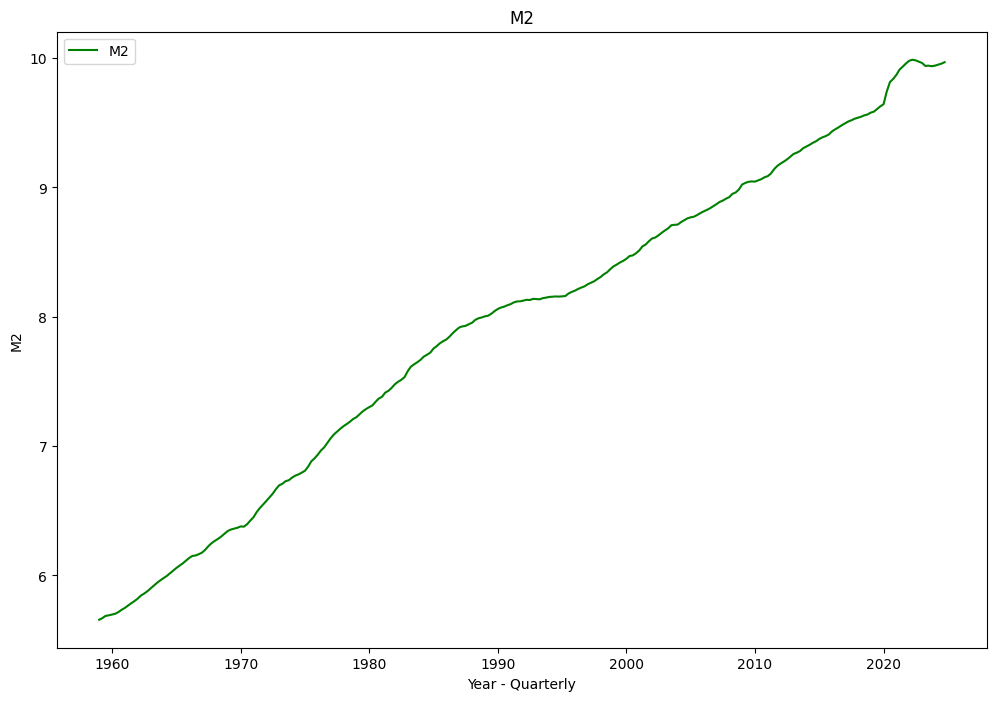

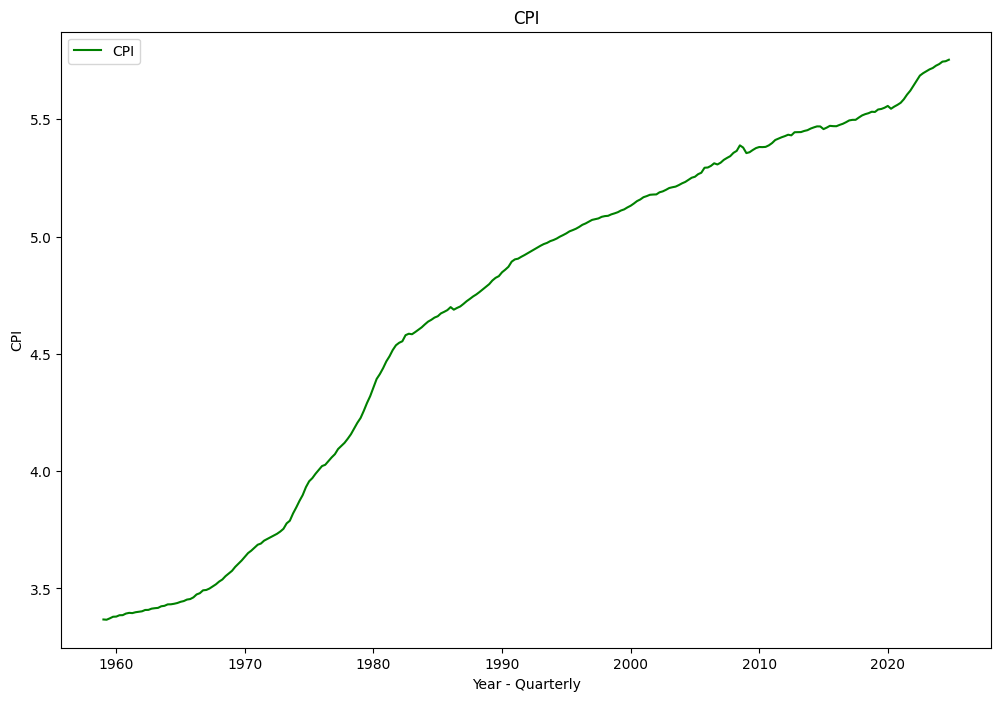

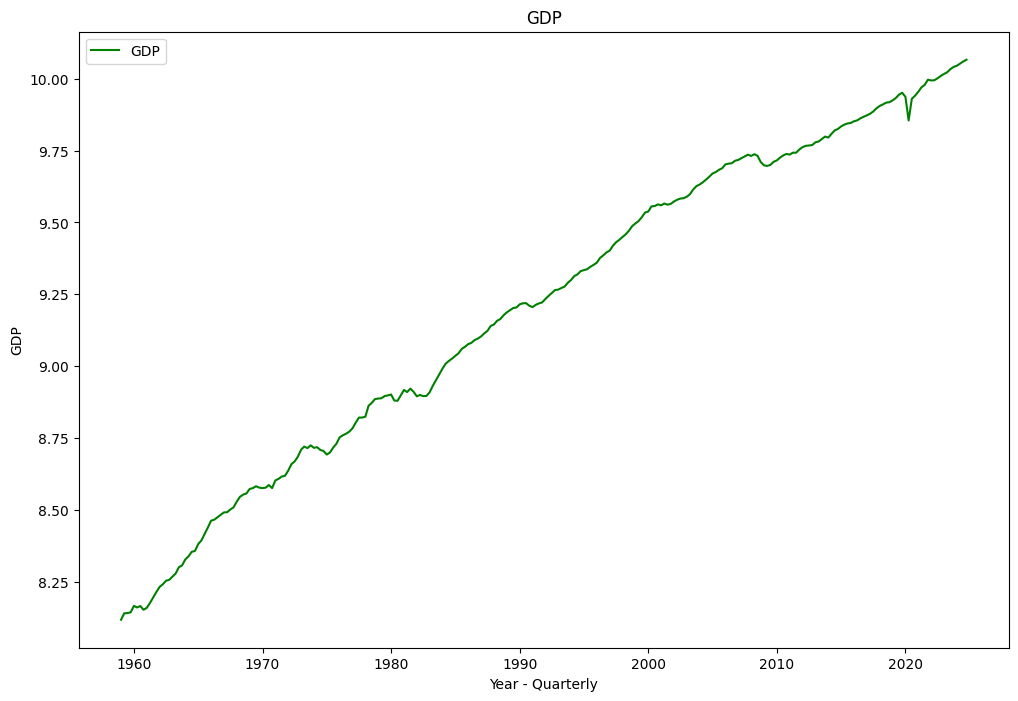

In [37]:
# taking logarithm of M2, CPI and GDP
df['M2'] = np.log(df['M2'])
df['CPI'] = np.log(df['CPI'])
df['GDP'] = np.log(df['GDP'])

Columns = ['M2', 'CPI', 'GDP']
for col in Columns:
    plt.figure(figsize=(12,8))
    plt.plot(df.index,df[col], label=col, color='green')
    plt.title(col)
    plt.xlabel('Year - Quarterly')
    plt.ylabel(col)
    plt.legend()
    plt.show()

## KPSS Stationarity and ADF unit root tests 

we test our time series for stationarity and unit roots, by visual inspections, we expect all of them to clearly reject stationarity and possess a unit root due to the trend

In [39]:
# # We first plot ACF and PACF for each of the three series
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for col in Columns:
#     plt.figure(figsize=(12,8))
#     plot_acf(df[col], lags=40, ax=plt.gca())
#     plt.title(f'ACF of {col}')
#     plt.show()

#     plt.figure(figsize=(12,8))
#     plot_pacf(df[col], lags=40, ax=plt.gca())
#     plt.title(f'PACF of {col}')
#     plt.show()

In [46]:
# DO Stationarity tests and ADF tests for each column
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(series):
    result = adfuller(series, autolag='BIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Stationary")
    else:
        print("Fail to reject the null hypothesis - Non-stationary")

def kpss_test(series):
    statistic, p_value, lags, critical_values = kpss(series, regression='c')
    print('KPSS Statistic: %f' % statistic)
    print('p-value: %f' % p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print('\t%s: %.3f' % (key, value))
    if p_value <= 0.05:
        print("Reject the null hypothesis - Non-stationary")
    else:
        print("Fail to reject the null hypothesis - Stationary")

for col in Columns:
    print(f"ADF test for {col}:")
    adf_test(df[col])
    print(f"\nKPSS test for {col}:")
    kpss_test(df[col])
    print("\n" + "="*50 + "\n")

ADF test for M2:
ADF Statistic: -1.517897
p-value: 0.524640
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Fail to reject the null hypothesis - Non-stationary

KPSS test for M2:
KPSS Statistic: 2.461062
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Reject the null hypothesis - Non-stationary


ADF test for CPI:
ADF Statistic: -1.439850
p-value: 0.563029
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Fail to reject the null hypothesis - Non-stationary

KPSS test for CPI:
KPSS Statistic: 2.408175
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Reject the null hypothesis - Non-stationary


ADF test for GDP:
ADF Statistic: -2.508644
p-value: 0.113385
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573
Fail to reject the null hypothesis - Non-stationary

KPSS test for GDP:
KPSS Statistic: 2.486791
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Reject the null hypothesis -

C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\394845541.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression='c')
C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\394845541.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression='c')
C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\394845541.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression='c')


I code my own ADF and KPSS test to compare my results to:

In [48]:
def adf_test(y, max_lag, regression='c'):
    """
    Perform the Augmented Dickey–Fuller test on a univariate series y.

    Parameters
    ----------
    y : array‐like or pandas.Series
        The time series to test (must be 1D, no missing values).
    max_lag : int
        Number of lagged Δy terms to include (p in the ADF(p) regression).
    regression : {'nc', 'c', 'ct'}
        'nc' : no constant, no trend
        'c'  : constant only
        'ct' : constant and linear trend

    Returns
    -------
    adf_stat : float
        The ADF test statistic (t‐ratio on the coefficient of y_{t-1}).
    nobs : int
        Number of observations used in the regression.
    df_m : int
        Number of regressors (including intercept/trend).
    """
    # 1. Prepare the data
    y = pd.Series(y).dropna()
    n = len(y)
    dy = y.diff().iloc[1:]  # Δy_t = y_t - y_{t-1}
    
    # we lose max_lag+1 observations in constructing lags
    t0 = max_lag + 1
    nobs = n - t0

    # 2. Build the regression matrix X
    # 2a. Lagged level y_{t-1}
    y_lag = y.shift(1).iloc[t0:]
    X = pd.DataFrame({'y_lag': y_lag})

    # 2b. Lagged differences Δy_{t-1}, …, Δy_{t-p}
    for lag in range(1, max_lag + 1):
        X[f'dy_lag{lag}'] = dy.shift(lag).iloc[t0 - 1:]

    # 2c. Deterministic terms
    if regression in ('c', 'ct'):
        X['const'] = 1.0
    if regression == 'ct':
        # time trend t = 0,1,2,... starting at the first used obs
        X['trend'] = np.arange(nobs)

    # 3. Align dependent variable
    y_dep = dy.iloc[t0 - 1:]  # Δy_t from t = max_lag+1 onward

    # 4. Estimate OLS: beta = (X'X)^{-1} X'y
    X_mat = X.values
    y_mat = y_dep.values.reshape(-1, 1)
    betas = np.linalg.lstsq(X_mat, y_mat, rcond=None)[0].flatten()

    # 5. Compute residuals and estimate sigma^2
    resid = y_mat.flatten() - X_mat.dot(betas)
    df_m = X_mat.shape[1]
    sigma2 = (resid @ resid) / (nobs - df_m)

    # 6. Compute t‐statistic for γ (coefficient on y_{t-1})
    #    Var(β) = σ² * (X'X)^{-1}; index 0 corresponds to y_lag
    xtx_inv = np.linalg.inv(X_mat.T.dot(X_mat))
    se_betas = np.sqrt(np.diag(xtx_inv) * sigma2)
    adf_stat = betas[0] / se_betas[0]

    return adf_stat, nobs, df_m

In [ ]:
# 'nc' : no constant, no trend
# 'c'  : constant only
# 'ct' : constant and linear trend
tests = ['nc', 'c', 'ct']

for col in Columns:
    for test in tests:
        result = adf_test(df[col], max_lag=4, regression=test)
        #limit the output to 3 decimal places
        result = [round(x, 3) for x in result]
        print(f"ADF test statistic for {col} and {test}: {result[0]}")
        #compare to critical values
        if test == 'nc':
            critical_values = {'1%': -2.57, '5%': -1.94, '10%': -1.62}
        elif test == 'c':
            critical_values = {'1%': -3.43, '5%': -2.86, '10%': -2.57}
        elif test == 'ct':
            critical_values = {'1%': -4.03, '5%': -3.45, '10%': -3.14}

    print("\n" + "="*50 + "\n")

ADF test statistic for M2 and nc: 4.079
ADF test statistic for M2 and c: -1.569
ADF test statistic for M2 and ct: -1.773


ADF test statistic for CPI and nc: 2.47
ADF test statistic for CPI and c: -1.534
ADF test statistic for CPI and ct: -1.055


ADF test statistic for GDP and nc: 5.45
ADF test statistic for GDP and c: -2.069
ADF test statistic for GDP and ct: -1.903




In [56]:
for col in Columns:
    print(f"ADF test for {col}:")
    # ADF with no constant ('nc')
    result_nc = adfuller(df[col], maxlag=4, regression='n')
    # ADF with constant only ('c')
    result_c = adfuller(df[col], maxlag=4, regression='c')
    # ADF with constant and trend ('ct')
    result_ct = adfuller(df[col], maxlag=4, regression='ct')
    #creating a table with the results
    results = pd.DataFrame({
        'ADF Statistic': [result_nc[0], result_c[0], result_ct[0]],
        'p-value': [result_nc[1], result_c[1], result_ct[1]]
    }, index=['No Constant', 'Constant', 'Constant and Trend'])
    print(round(results,3))
    print("\n" + "="*50 + "\n")

ADF test for M2:
                    ADF Statistic  p-value
No Constant                 3.875    1.000
Constant                   -1.569    0.499
Constant and Trend         -1.773    0.718


ADF test for CPI:
                    ADF Statistic  p-value
No Constant                 2.539    0.998
Constant                   -1.440    0.563
Constant and Trend         -1.031    0.940


ADF test for GDP:
                    ADF Statistic  p-value
No Constant                11.054    1.000
Constant                   -2.509    0.113
Constant and Trend         -1.841    0.685


